# Induced Vertical Break Project - What are its contributing factors?

I will be investigating the factors that influence Induced Vertical Break on fastballs using in-game data collected at Triton Ballpark in San Diego with our Yakkertech. The factors I will be using for prediction are Spin Rate, Spin Efficiency, Spin Axis, Tilt, Velocity, Extension, and Gyro Spin. I will first find the best regression model to predict IVB based on these factors, then I will use the coefficients from the regression model to determine the metric(s) that have the most influence on IVB. From experience, I would guess that these factors would be Spin Axis (or Tilt) and Spin Efficiency, but finding a way to quantify each metric's importance in influencing IVB would be useful in pitch design.

In [132]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm
import patsy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

In [11]:
games = os.listdir('YakkertechData')[:-4]
dflst = []
for game in games:
    dflst.append(pd.read_csv(os.path.join('YakkertechData', game)))
allgamedata = pd.concat(dflst)
allgamedata

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,yt_HitSpinConfidence,yt_EffectiveBattingSpeed,yt_ReleaseAccuracy,yt_ZoneAccuracy,yt_SeamLat,yt_SeamLong,yt_ReleaseDistance,Catcher,CatcherId,CatcherTeam
0,1,01/20/2023,1:03:24 PM,1,1,Nolan Mccracken,mccrano42,Right,Uc san diego,Bradlee Preap,...,NaN,NaN,high,high,16.649588,-23.315828,53.231277,NaN,NaN,NaN
1,2,01/20/2023,1:03:52 PM,1,2,Nolan Mccracken,mccrano42,Right,Uc san diego,Bradlee Preap,...,NaN,NaN,high,high,11.755224,-3.302182,53.335639,NaN,NaN,NaN
2,3,01/20/2023,1:04:12 PM,1,3,Nolan Mccracken,mccrano42,Right,Uc san diego,Bradlee Preap,...,NaN,NaN,high,high,27.008184,-71.725414,53.508536,NaN,NaN,NaN
3,4,01/20/2023,1:04:34 PM,2,1,Nolan Mccracken,mccrano42,Right,Uc san diego,Bradlee Preap,...,NaN,NaN,high,high,40.351346,-15.92502,53.451727,NaN,NaN,NaN
4,5,01/20/2023,1:05:06 PM,2,2,Nolan Mccracken,mccrano42,Right,Uc san diego,Ben Pajak,...,NaN,NaN,high,high,44.363811,57.32922,53.270835,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,75,11/16/2022,9:22:22 AM,2,3,Zachary Ernisse,NaN,Left,Uc san diego,Crew Robinson,...,NaN,35.545796,high,high,NaN,NaN,54.252345,NaN,NaN,NaN
75,76,11/16/2022,9:22:50 AM,3,1,Zachary Ernisse,NaN,Left,Uc san diego,Brock Kleszcz,...,NaN,NaN,high,low,NaN,NaN,54.295606,NaN,NaN,NaN
76,77,11/16/2022,9:23:04 AM,3,2,Zachary Ernisse,NaN,Left,Uc san diego,Brock Kleszcz,...,NaN,NaN,high,high,NaN,NaN,54.309256,NaN,NaN,NaN
77,78,11/16/2022,9:23:18 AM,3,3,Zachary Ernisse,NaN,Left,Uc san diego,Brock Kleszcz,...,NaN,NaN,high,high,NaN,NaN,54.171285,NaN,NaN,NaN


In [12]:
allFB = allgamedata[allgamedata.TaggedPitchType == 'Fastball']
allFB = allFB[['PitcherThrows', 'InducedVertBreak', 'VertBreak', 'yt_Efficiency', 'SpinRate', 'Tilt', 'SpinAxis', 'RelSpeed', 'Extension', 'yt_GyroSpin']]
allFB = allFB.dropna()
allFB

,PitcherThrows,InducedVertBreak,VertBreak,yt_Efficiency,SpinRate,Tilt,SpinAxis,RelSpeed,Extension,yt_GyroSpin
0,Right,15.39505,-15.225392,95.698067,2243.318786,12:45,203.456409,93.181195,7.268723,-650.902744
1,Right,16.128602,-13.920308,94.001842,2331.242797,12:30,197.571868,94.325621,7.164361,-795.242167
4,Right,15.309531,-14.720538,96.571451,2267.534131,12:45,204.779323,93.436131,7.229165,-588.66639
7,Right,15.150609,-15.166215,96.021025,2268.054005,12:45,205.624413,93.044028,7.239898,-633.417894
9,Right,15.560563,-15.003616,90.68013,2333.037235,12:45,201.631627,93.545168,7.130828,-983.511218
...,...,...,...,...,...,...,...,...,...,...
52,Right,14.135811,-18.121188,98.936835,2127.864821,1:15,214.473261,92.392651,6.574396,-309.458231
63,Right,15.17802,-16.649501,96.392116,2250.741728,1:00,209.48167,92.254524,6.805102,-599.120213
69,Left,14.034552,-20.771267,99.599001,1952.257876,10:45,145.862809,89.870935,6.085815,-174.657719
70,Left,14.15857,-19.962815,99.003777,1933.897393,11:00,148.918086,91.72484,6.18387,-272.296665


Convert Tilt into a numerical value by assigning it a number I call "tiltpoints", which represents the tilt in "minutes" instead of the "hour:minute" clock format the tilt is collected in. The tilt_from_12 function will return the magnitude of the tilt away from 12:00, or straight over the top. Lower numbers will represent tilts higher up on the clock and bigger numbers will represent tilts lower on the clock. Tilts lower than 3 or 9 will be discarded as null, as those were likely misreads, and any pitch marked with lower than 50% efficiency is taken out due to its likelihood the pitch was a higher tilt slider mistagged as a fastball

In [13]:
def tilt_from_12(tilt):
    colonpos = tilt.find(':')
    hour = tilt[:colonpos]
    minute = tilt[colonpos+1:]
    if hour == '9':
        tiltpts = 180 - int(minute)
    elif hour == '10':
        tiltpts = 120 - int(minute)
    elif hour == '11':
        tiltpts = 60 - int(minute)
    elif hour == '12':
        tiltpts = int(minute)
    elif hour == '1':
        tiltpts = 60 + int(minute)
    elif hour == '2':
        tiltpts = 120 + int(minute)
    else:
        tiltpts = np.nan
    return tiltpts
tiltc = allFB.Tilt.apply(tilt_from_12)
allFBclean = allFB.assign(Tilt = tiltc)
allFBclean = allFBclean[allFBclean.yt_Efficiency >= 50]
allFBclean

,PitcherThrows,InducedVertBreak,VertBreak,yt_Efficiency,SpinRate,Tilt,SpinAxis,RelSpeed,Extension,yt_GyroSpin
0,Right,15.39505,-15.225392,95.698067,2243.318786,45.0,203.456409,93.181195,7.268723,-650.902744
1,Right,16.128602,-13.920308,94.001842,2331.242797,30.0,197.571868,94.325621,7.164361,-795.242167
4,Right,15.309531,-14.720538,96.571451,2267.534131,45.0,204.779323,93.436131,7.229165,-588.66639
7,Right,15.150609,-15.166215,96.021025,2268.054005,45.0,205.624413,93.044028,7.239898,-633.417894
9,Right,15.560563,-15.003616,90.68013,2333.037235,45.0,201.631627,93.545168,7.130828,-983.511218
...,...,...,...,...,...,...,...,...,...,...
52,Right,14.135811,-18.121188,98.936835,2127.864821,75.0,214.473261,92.392651,6.574396,-309.458231
63,Right,15.17802,-16.649501,96.392116,2250.741728,60.0,209.48167,92.254524,6.805102,-599.120213
69,Left,14.034552,-20.771267,99.599001,1952.257876,75.0,145.862809,89.870935,6.085815,-174.657719
70,Left,14.15857,-19.962815,99.003777,1933.897393,60.0,148.918086,91.72484,6.18387,-272.296665


In [14]:
allFBclean.rename(columns = {'InducedVertBreak':'IVB', 'VertBreak':'VB', 'yt_Efficiency':'Efficiency', 
                             'SpinRate':'SpinRate', 'Tilt':'Tilt', 'SpinAxis':'SpinAxis', 
                             'RelSpeed': 'Velocity', 'Extension': 'Extension', 'yt_GyroSpin': 'GyroSpin'}, 
                  inplace = True)
allFBclean

,PitcherThrows,IVB,VB,Efficiency,SpinRate,Tilt,SpinAxis,Velocity,Extension,GyroSpin
0,Right,15.39505,-15.225392,95.698067,2243.318786,45.0,203.456409,93.181195,7.268723,-650.902744
1,Right,16.128602,-13.920308,94.001842,2331.242797,30.0,197.571868,94.325621,7.164361,-795.242167
4,Right,15.309531,-14.720538,96.571451,2267.534131,45.0,204.779323,93.436131,7.229165,-588.66639
7,Right,15.150609,-15.166215,96.021025,2268.054005,45.0,205.624413,93.044028,7.239898,-633.417894
9,Right,15.560563,-15.003616,90.68013,2333.037235,45.0,201.631627,93.545168,7.130828,-983.511218
...,...,...,...,...,...,...,...,...,...,...
52,Right,14.135811,-18.121188,98.936835,2127.864821,75.0,214.473261,92.392651,6.574396,-309.458231
63,Right,15.17802,-16.649501,96.392116,2250.741728,60.0,209.48167,92.254524,6.805102,-599.120213
69,Left,14.034552,-20.771267,99.599001,1952.257876,75.0,145.862809,89.870935,6.085815,-174.657719
70,Left,14.15857,-19.962815,99.003777,1933.897393,60.0,148.918086,91.72484,6.18387,-272.296665


Very messy data - lots of observations that don't make sense
Solution: Choose ranges for each metric to analyze - wide enough to include all good data but narrow enough to discard outliers
- IVB: 7"-22"
- Efficiency: 50%-100%
- Spin Rate: 1500rpm-3000rpm
- Tilt: 9:00-12:00, 12:00-3:00
- Velo: 77-100
- Extension: 5'-8'

In [107]:
allFBclean = allFBclean[((allFBclean.IVB > 7) & (allFBclean.IVB < 22))
                       & ((allFBclean.get('SpinRate') > 1500) & (allFBclean.get('SpinRate') < 3000))
                       & ((allFBclean.Velocity > 77) & (allFBclean.Velocity < 100))
                       & ((allFBclean.Extension > 5) & (allFBclean.Extension < 8))]
allFBclean

,PitcherThrows,IVB,VB,Efficiency,SpinRate,Tilt,SpinAxis,Velocity,Extension,GyroSpin
0,Right,15.39505,-15.225392,95.698067,2243.318786,45.0,203.456409,93.181195,7.268723,-650.902744
1,Right,16.128602,-13.920308,94.001842,2331.242797,30.0,197.571868,94.325621,7.164361,-795.242167
4,Right,15.309531,-14.720538,96.571451,2267.534131,45.0,204.779323,93.436131,7.229165,-588.66639
7,Right,15.150609,-15.166215,96.021025,2268.054005,45.0,205.624413,93.044028,7.239898,-633.417894
9,Right,15.560563,-15.003616,90.68013,2333.037235,45.0,201.631627,93.545168,7.130828,-983.511218
...,...,...,...,...,...,...,...,...,...,...
52,Right,14.135811,-18.121188,98.936835,2127.864821,75.0,214.473261,92.392651,6.574396,-309.458231
63,Right,15.17802,-16.649501,96.392116,2250.741728,60.0,209.48167,92.254524,6.805102,-599.120213
69,Left,14.034552,-20.771267,99.599001,1952.257876,75.0,145.862809,89.870935,6.085815,-174.657719
70,Left,14.15857,-19.962815,99.003777,1933.897393,60.0,148.918086,91.72484,6.18387,-272.296665


Identify relationships between variables and IVB using scatterplots

<AxesSubplot:xlabel='Efficiency', ylabel='IVB'>

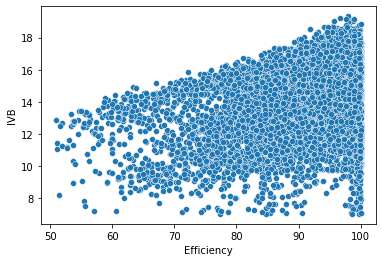

In [108]:
sns.scatterplot(x = 'Efficiency', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='SpinRate', ylabel='IVB'>

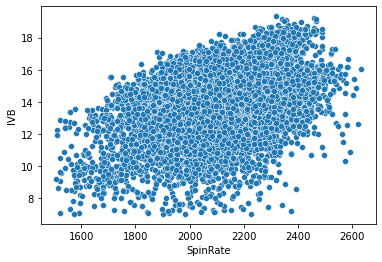

In [109]:
sns.scatterplot(x = 'SpinRate', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='Tilt', ylabel='IVB'>

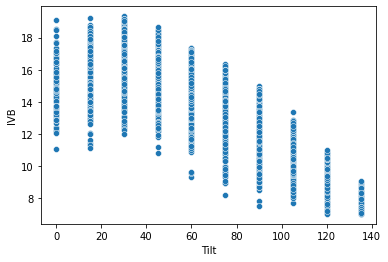

In [110]:
sns.scatterplot(x = 'Tilt', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='SpinAxis', ylabel='IVB'>

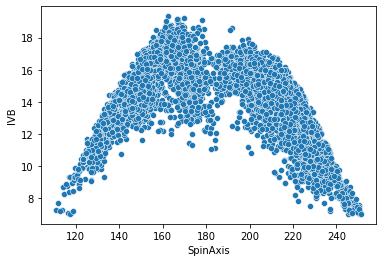

In [111]:
sns.scatterplot(x = 'SpinAxis', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='Velocity', ylabel='IVB'>

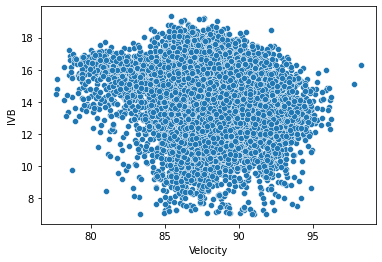

In [112]:
sns.scatterplot(x = 'Velocity', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='Extension', ylabel='IVB'>

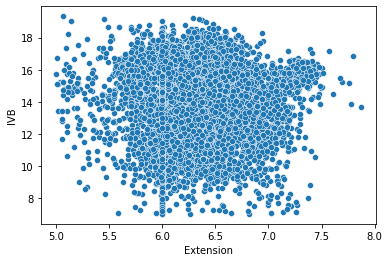

In [113]:
sns.scatterplot(x = 'Extension', y = 'IVB', data = allFBclean)

<AxesSubplot:xlabel='GyroSpin', ylabel='IVB'>

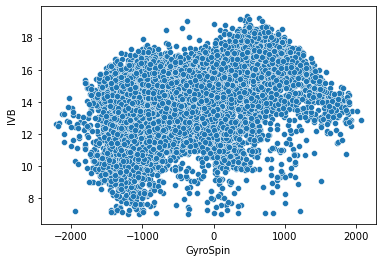

In [114]:
sns.scatterplot(x = 'GyroSpin', y = 'IVB', data = allFBclean)

Features chosen for regression analysis:
- Spin Rate
- Spin Efficiency
- Spin Axis
- Velocity
- Extension
- Gyro Spin

Tilt will not be used as it is pretty much the same metric as Spin Axis, but at 15 minute intervals, so the accuracy would likely be less accurate using tilt than Spin Axis. Velocity and Extension show no correlation when compared to IVB in the single variable scatterplots, but they will be left in to see if there is a correlation in the multi-dimensional regression analysis.

In [115]:
X = allFBclean.drop(columns = ['IVB', 'VB', 'Tilt', 'PitcherThrows']).astype(float)
y = allFBclean['IVB'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train

,Efficiency,SpinRate,SpinAxis,Velocity,Extension,GyroSpin
13,99.298976,1982.908436,156.329045,91.632914,6.151842,-234.380610
16,67.071035,2083.013386,223.345414,87.032956,6.237628,-1545.011371
204,99.882120,1965.791185,127.734617,86.657641,6.076353,-95.421182
207,77.099293,2102.028789,230.965150,85.536404,5.736788,-1338.663804
2,99.586647,2168.417935,221.905757,92.762288,6.796626,-196.956135
...,...,...,...,...,...,...
199,98.717244,2404.915995,160.406899,90.478133,6.751230,383.963239
92,99.811184,2189.918475,221.232296,90.834428,6.857916,-134.510663
2,91.317328,1965.982340,153.117910,91.834230,6.117395,-801.278446
16,93.059127,2210.490221,172.644356,90.145201,6.000000,809.171952


## Initial Model - All 6 Features, Quadratic Term for Spin Axis

In [147]:
proc = ColumnTransformer(
    transformers = [('quad', PolynomialFeatures(degree=2), ['SpinAxis'])],
    remainder = 'passthrough'
)
pl1 = Pipeline([
    ('preprocessor', proc),
    ('lin-reg', LinearRegression())
]).fit(X_train, y_train)
pl1_pred = pl1.predict(X_test)
train_rmse1 = np.sqrt(mean_squared_error(pl1.predict(X_train), np.array(y_train)))
print('train RMSE Model 1: ' + str(train_rmse1))
test_rmse1 = np.sqrt(mean_squared_error(pl1_pred, np.array(y_test)))
print('test RMSE Model 1: ' + str(test_rmse1))
r2 = r2_score(y_train, pl1.predict(X_train))
print('R^2: ' + str(r2))

train RMSE Model 1: 0.2974568856433726
test RMSE Model 1: 0.29843677783571293
R^2: 0.9812491994363097


In [117]:
print('Coefficients: ' + str(pl1.get_params()['lin-reg'].coef_))
print('Intercept: ' + str(pl1.get_params()['lin-reg'].intercept_))

Coefficients: [ 0.00000000e+00  7.11309125e-01 -1.97585310e-03  9.45894771e-02
  4.57410429e-03 -1.54821493e-01 -4.98522937e-01 -7.23344513e-05]
Intercept: -48.99558613271695


<AxesSubplot:xlabel='IVB', ylabel='Count'>

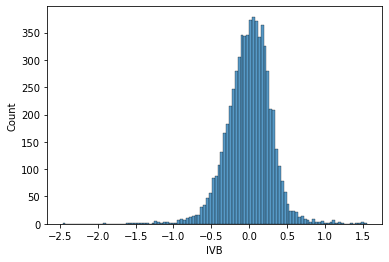

In [118]:
#Check assumption: normality of residuals
sns.histplot(pl1.predict(X_train) - y_train)

In [119]:
#Check assumption: Average value of residuals = 0
np.mean(pl1.predict(X_train) - y_train)

2.2247929434804277e-13

[Text(0, 0.5, 'Residuals')]

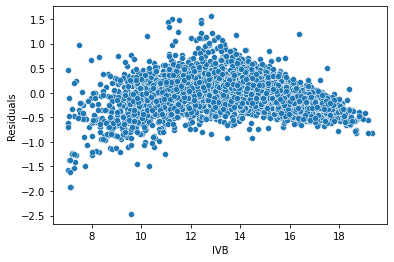

In [120]:
#Check assumption: Constant Variance of Residuals/Homoscedasticity
sns.scatterplot(x = y_train, y = pl1.predict(X_train) - y_train).set(ylabel = 'Residuals')

In [121]:
#Check assumption: Autocorrelation
from statsmodels.stats.stattools import durbin_watson
durbin_watson(pl1.predict(X_train) - y_train)

2.0143737232541903

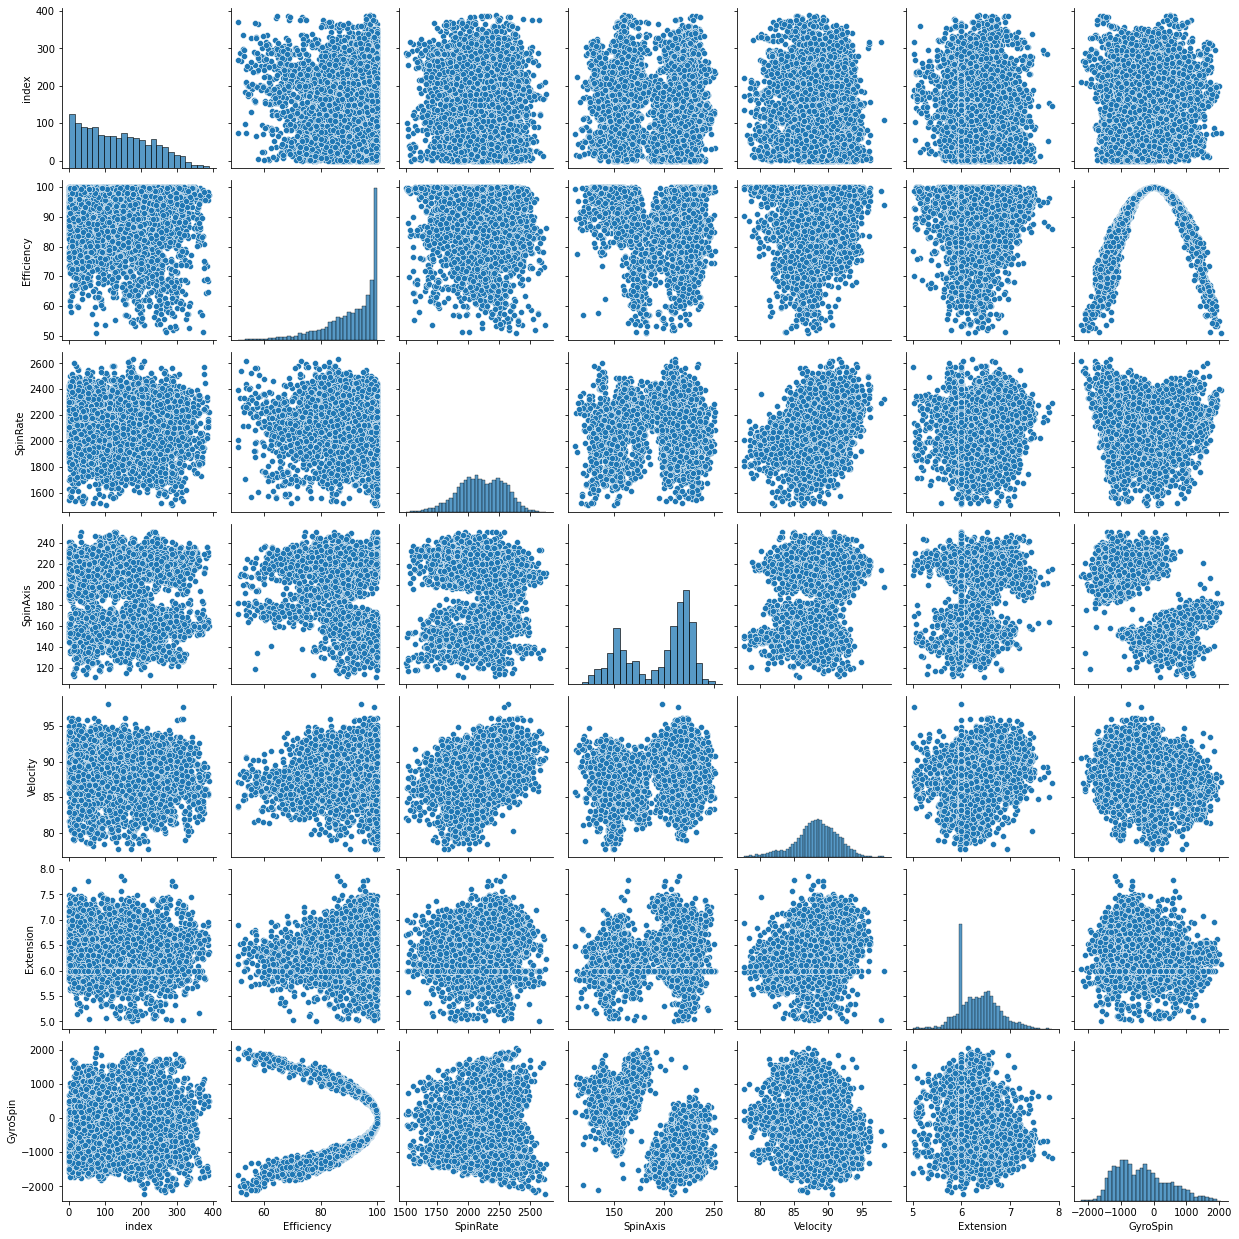

In [122]:
#Check assumption: Multicollinearity
sns.pairplot(X_train.reset_index())

This model performed very well, with a RMSE of 0.29 on the test and training data. All the assumptions for linear regression held except for Multicollinearity, as the scatter matrix above reveals. In it, it can be seen that there is a positive relationship between velocity and spin rate, and a parabolic relationship between efficiency and gyro spin. Both of these findings make sense from a physics standpoint. Harder throwing pitchers input more force into the ball, which causes it to move faster and spin more. Velocity comes from the linear force exerted through the center of the ball, and spin rate comes from the amount of tangential force exterted on the outside of the ball. There can be variation in the correlation between spin rate and velocity if a pitcher applies relatively more linear force than tangential force (high velocity, low spin rate) or relatively more tangential force than linear force (high spin rate, low velocity). However, it is typical for a pitcher applying more linear force (high velocity) to also apply more tangential force (high spin rate), causing the two to be correlated. The relationship between efficiency and gyro spin is caused by the metrics being inverses of each other. Spin efficiency refers to the amount of true backspin or topspin, while gyro spin refers to the amount of bullet-like spin on the ball. Therefore, if a ball has perfectly true backspin, it has 0 gyro spin and 100% spin efficiency. If a ball has 0% spin efficiency, all of its spin is gyro spin. This effect causes the parabolic relationship seen on the chart, with the vertex of the parabola at Efficiency = 100 and GyroSpin = 0. In future models, I will choose to remove gyro spin and keep efficiency, as it is an easier metric to interpret and more relevant for fastballs, where the goal is to achieve backspin. For the next models, I will leave out velocity and keep spin rate, as induced vertical break is supposed to be a metric independent of velocity, but I will run a model combining spin rate and velocity in Bauer units (SpinRate/Velocity).

## Model 2 - All 6 Features, Linear Transformation for Spin Axis

For a second linear regression model, the SpinAxis column will to be linearized to avoid the use of a quadratic feature. As seen in the scatterplot above, there is not a linear relationship between IVB and Spin Axis. Its lack of linearity comes from the way the metric is calculated. It is circular, with 0/360 degrees representing directly downward spin, 180 degrees represeting directly upward spin, 90 degrees representing leftward spin (from the pitcher's perspective), and 270 degrees representing rightward spin. Fastballs will have upward spin, so the distance between the true spin axis of the pitch and 180 degrees is important. As seen in the scatterplot, there seems to be a gap at 180 degrees, right where the peak of a parabola of best fit may be. Left handed pitchers will throw fastballs on the left side of that gap, having spin axes between 90 and 180 degrees, and right handed pitchers will throw fastballs on the right side of the gap, between 180 and 270 degrees. To control for the handedness of the pitcher, and linearize the relationship between IVB and Spin Axis, the absolute difference of the Spin Axis and 180 will be used for the regression model.

The transformation and new scatterplot is shown below.

<AxesSubplot:xlabel='SpinAxis', ylabel='IVB'>

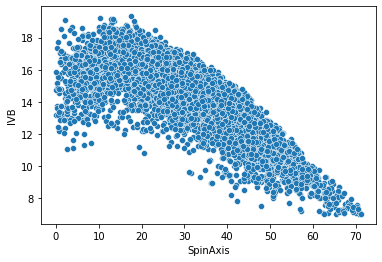

In [123]:
sns.scatterplot(x = abs(allFBclean['SpinAxis'] - 180), y = allFBclean['IVB'])

In [146]:
proc2 = ColumnTransformer(
    transformers = [('conv', FunctionTransformer(lambda x: abs(x-180)), ['SpinAxis'])],
    remainder = 'passthrough'
)
pl2 = Pipeline([
    ('preprocessor', proc2),
    ('lin-reg', LinearRegression())
]).fit(X_train, y_train)
pl2_pred = pl2.predict(X_test)
train_rmse2 = np.sqrt(mean_squared_error(pl2.predict(X_train), np.array(y_train)))
print('train RMSE Model 1: ' + str(train_rmse2))
test_rmse2 = np.sqrt(mean_squared_error(pl2_pred, np.array(y_test)))
print('test RMSE Model 1: ' + str(test_rmse2))
r2_2 = r2_score(y_train, pl2.predict(X_train))
print('R^2: ' + str(r2_2))

train RMSE Model 1: 0.46029587060214905
test RMSE Model 1: 0.468164521374207
R^2: 0.9551000436294015


In [125]:
print('Coefficients: ' + str(pl2.get_params()['lin-reg'].coef_))
print('Intercept: ' + str(pl2.get_params()['lin-reg'].intercept_))

Coefficients: [-1.33463197e-01  1.16619311e-01  4.52378596e-03 -1.66198650e-01
 -5.25468916e-01 -3.26554452e-04]
Intercept: 16.116241854441668


<AxesSubplot:xlabel='IVB', ylabel='Count'>

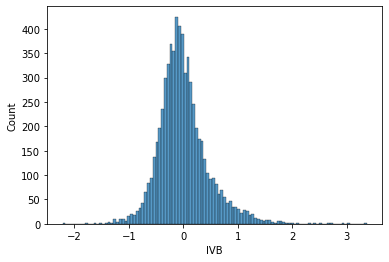

In [126]:
#Check assumption: normality of residuals
sns.histplot(pl2.predict(X_train) - y_train)

In [127]:
#Check assumption: Average value of residuals = 0
np.mean(pl2.predict(X_train) - y_train)

2.2562193387296313e-15

[Text(0, 0.5, 'Residuals')]

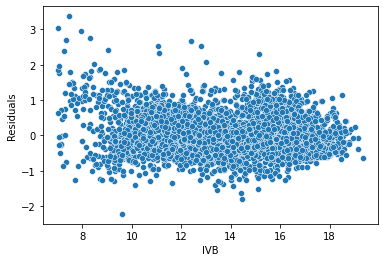

In [128]:
#Check assumption: Constant Variance of Residuals/Homoscedasticity
sns.scatterplot(x = y_train, y = pl2.predict(X_train) - y_train).set(ylabel = 'Residuals')

In [129]:
#Check assumption: Autocorrelation
durbin_watson(pl2.predict(X_train) - y_train)

1.9905356073330056

This model performed worse than the initial model, but I believe it will be useful in finding which factors are the most important in determining induced vertical break. Since all the features are linear, the coefficients are easily interpretable and can be compared using normalization by z-score. This will be done in model 7

## Model 3 - Lasso

In Model 3, I will run a Lasso regression model to determine which of the remaining 4 factors (after removing Gyro Spin and Velocity), if any, can be removed.

In [145]:
X_train_trans = X_train.copy()
X_train_trans['SpinAxis'] = X_train_trans['SpinAxis'].apply(lambda x: abs(x-180))
X_test_trans = X_test.copy()
X_test_trans['SpinAxis'] = X_test_trans['SpinAxis'].apply(lambda x: abs(x-180))
las = linear_model.LassoCV(cv = 5, random_state = 42).fit(X_train_trans[['Efficiency', 'SpinRate', 'SpinAxis', 'Extension']], y_train)
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test,las.predict(X_test_trans[['Efficiency', 'SpinRate', 'SpinAxis', 'Extension']])))))
print('Coefficients: '+ str(las.coef_))

RMSE: 0.7190187974734168
Coefficients: [ 0.09764398  0.00341423 -0.1301724  -0.        ]


The fourth coefficient, which is the Extension coefficient, was squeezed to 0, meaning it is not relevant to the model. It will be dropped in future models.

## Model 4 - Re-run model 1 without Extension, Velocity, Gyro Spin

In [148]:
pl4 = Pipeline([
    ('preprocessor', proc),
    ('lin-reg', LinearRegression())
]).fit(X_train[['Efficiency', 'SpinRate', 'SpinAxis']], y_train)
pl4_pred = pl4.predict(X_test[['Efficiency', 'SpinRate', 'SpinAxis']])
train_rmse4 = np.sqrt(mean_squared_error(pl4.predict(X_train[['Efficiency', 'SpinRate', 'SpinAxis']]), np.array(y_train)))
print('train RMSE Model 4: ' + str(train_rmse4))
test_rmse4 = np.sqrt(mean_squared_error(pl4_pred, np.array(y_test)))
print('test RMSE Model 4: ' + str(test_rmse4))
r2_4 = r2_score(y_train, pl4.predict(X_train[['Efficiency', 'SpinRate', 'SpinAxis']]))
print('R^2: ' + str(r2_4))

train RMSE Model 4: 0.5738732724124986
test RMSE Model 4: 0.5847293524685535
R^2: 0.930208303035285


In [165]:
print('Coefficients: ' + str(pl4.get_params()['lin-reg'].coef_))
print('Intercept: ' + str(pl4.get_params()['lin-reg'].intercept_))

Coefficients: [ 0.          0.70200434 -0.00196147  0.08157613  0.00357867]
Intercept: -61.27806269026816


## Model 5 - Re-run model 2 without Extension, Velocity, Gyro Spin

In [149]:
pl5 = Pipeline([
    ('preprocessor', proc2),
    ('lin-reg', LinearRegression())
]).fit(X_train[['Efficiency', 'SpinRate', 'SpinAxis']], y_train)
pl5_pred = pl5.predict(X_test[['Efficiency', 'SpinRate', 'SpinAxis']])
train_rmse5 = np.sqrt(mean_squared_error(pl5.predict(X_train[['Efficiency', 'SpinRate', 'SpinAxis']]), np.array(y_train)))
print('train RMSE Model 5: ' + str(train_rmse5))
test_rmse5 = np.sqrt(mean_squared_error(pl5_pred, np.array(y_test)))
print('test RMSE Model 5: ' + str(test_rmse5))
r2_5 = r2_score(y_train, pl5.predict(X_train[['Efficiency', 'SpinRate', 'SpinAxis']]))
print('R^2: ' + str(r2_5))

train RMSE Model 5: 0.706882235751832
test RMSE Model 5: 0.7187352968681147
R^2: 0.894107330438839


In [166]:
print('Coefficients: ' + str(pl5.get_params()['lin-reg'].coef_))
print('Intercept: ' + str(pl5.get_params()['lin-reg'].intercept_))

Coefficients: [-0.13137239  0.09977351  0.00341164]
Intercept: 2.025070892497393


Models 5 and 6 both performed worse than their counterparts with all 6 features included. Ideally, these models would perform similarly to the models with the additional features, but would be more ideal to use due to their reduced number of features. I believe they performed worse due to the same pitchers appearing in the data often, causing the models to find trends where they don't truly exist in the real world. More on this in the section below Model 6.

## Model 6 - Efficiency, Spin Axis, Bauer Units

In [153]:
X_train_bauer = X_train.copy()
X_test_bauer = X_test.copy()
X_train_bauer['BauerUnits'] = X_train_bauer['SpinRate']/X_train_bauer['Velocity']
X_test_bauer['BauerUnits'] = X_test_bauer['SpinRate']/X_test_bauer['Velocity']

pl6 = Pipeline([
    ('preprocessor', proc),
    ('lin-reg', LinearRegression())
]).fit(X_train_bauer[['Efficiency', 'BauerUnits', 'SpinAxis']], y_train)
pl6_pred = pl6.predict(X_test_bauer[['Efficiency', 'BauerUnits', 'SpinAxis']])
train_rmse6 = np.sqrt(mean_squared_error(pl6.predict(X_train_bauer[['Efficiency', 'BauerUnits', 'SpinAxis']]), np.array(y_train)))
print('train RMSE Model 6: ' + str(train_rmse6))
test_rmse6 = np.sqrt(mean_squared_error(pl6_pred, np.array(y_test)))
print('test RMSE Model 6: ' + str(test_rmse6))
r2_6 = r2_score(y_train, pl6.predict(X_train_bauer[['Efficiency', 'BauerUnits', 'SpinAxis']]))
print('R^2: ' + str(r2_6))

train RMSE Model 6: 0.38934237905200547
test RMSE Model 6: 0.39735898193665203
R^2: 0.9678755931151762


In [167]:
print('Coefficients: ' + str(pl6.get_params()['lin-reg'].coef_))
print('Intercept: ' + str(pl6.get_params()['lin-reg'].intercept_))

Coefficients: [ 0.          0.6882725  -0.00191876  0.08711028  0.40283158]
Intercept: -62.83982045300597


The model with Bauer units instead of Spin Rate performed much better than its counterpart in model 4. This would give evidence that Bauer Units, the metric that combines Spin Rate and Velocity, is a better predictor of induced vertical break than just Spin Rate. However, there is a potential issue with the data I have that I have yet to mention. Since the data is only data collected by our Yakkertech at Triton Ballpark, the data consists of many more pitches thrown by Triton pitchers than anyone else. While I believe the trends seen are accurate, this issue becomes relevant when comparing velocity and induced vertical break. Velocity and induced vertical break are supposed to be completely independent of each other. That is the point of having induced vertical break as a metric instead of true vertical break, which measures the drop of the pitch from its original trajectory. True vertical break does depend on velocity, as faster pitches have less time to be influenced by gravity, and will therefore drop less. However, the regression models I have run indicate that induced vertical break also has a dependency on velocity. This brings me back to the data I have. Knowing that most of the pitches thrown are from UCSD pitchers, I know that we have slower throwing pitchers with high induced vertical break and some harder throwing pitchers with lower induced vertical break. For example, our pitcher with the highest average induced vertical break is Izaak Martinez. He gets between 17-19 inches of IVB throwing 85-89 mph. On the other hand, our hardest throwing pitcher is Ryan Forcucci, who throws 92-96 mph and only gets 11-13 inches of IVB. These two guys are also our two best pitchers, and they throw a lot, so pitches from them are frequent in the dataset

In [162]:
allgamedata[allgamedata.TaggedPitchType == 'Fastball']['Pitcher'].value_counts()

Izaak Martinez     703
Ryan Forcucci      514
Ryan Rissas        431
Anthony Eyanson    348
Seth Sumner        323
                  ... 
Sam Whiting          2
Brandon Bohning      1
Chase Grillo         1
Delshaun Lanier      1
Luke Saunders        1
Name: Pitcher, Length: 188, dtype: int64

Martinez and Forcucci threw 1217 of the 10110 fastballs in the original dataset, a pretty significant chunk. I believe this is where the negative correlation found between IVB and velocity in this data is coming from, and why the models with velocity included, like models 1, 2, and 6, peform better than the models without it, like models 3, 4, and 5. Velocity becomes a good predictor of IVB when a large chunk of lower velocity pitches from Martinez have high IVB and another large chunk of higher velocity pitches from Forcucci have low IVB. So, back to Bauer Units. Is it a better predictor of IVB than just using Spin Rate? I don't know. It cannot be determined using this dataset. Replicating these models with data from Statcast and MLB would be better. There would be a better distribution of pitchers and pitch shapes, so a more definitive  answer could be reached.

## Model 7 - Normalized Features

This model will find the relative importance of Efficiency, Spin Rate, and Spin Axis by z-scoring the data before running linear regression. Using this method places all the data on the same scale, so the coefficients can be compared for importance. The higher the magnitude of the coefficient, the more of an impact that feature has on the prediction.

Since all the features need to be on the linear scale for this to work, the same transformation applied to the Spin Axis column in Models 2 and 5 will be repeated here.

In [163]:
proc7 = ColumnTransformer(
    transformers = [('z', StandardScaler(), ['Efficiency', 'SpinRate', 'SpinAxis'])],
    remainder = 'passthrough'
)
pl7 = Pipeline([
    ('preprocessor', proc7),
    ('lin-reg', LinearRegression())
]).fit(X_train_trans[['Efficiency', 'SpinRate', 'SpinAxis']], y_train)
pl7_pred = pl7.predict(X_test_trans[['Efficiency', 'SpinRate', 'SpinAxis']])
train_rmse7 = np.sqrt(mean_squared_error(pl7.predict(X_train_trans[['Efficiency', 'SpinRate', 'SpinAxis']]), np.array(y_train)))
print('train RMSE Model 7: ' + str(train_rmse7))
test_rmse7 = np.sqrt(mean_squared_error(pl7_pred, np.array(y_test)))
print('test RMSE Model 7: ' + str(test_rmse7))
r2_7 = r2_score(y_train, pl7.predict(X_train_trans[['Efficiency', 'SpinRate', 'SpinAxis']]))
print('R^2: ' + str(r2_7))

train RMSE Model 7: 0.706882235751832
test RMSE Model 7: 0.7187352968681145
R^2: 0.894107330438839


In [164]:
print('Coefficients: ' + str(pl7.get_params()['lin-reg'].coef_))
print('Intercept: ' + str(pl7.get_params()['lin-reg'].intercept_))

Coefficients: [ 0.94871248  0.63885254 -1.74348697]
Intercept: 13.898183275558535


Comparing coefficients in model 7 reveals that Spin Axis is the most important metric in determining IVB, followed by Efficiency and Spin Rate. The large negative coefficient of -1.74 for Spin Axis means that the further away from a 180 degree spin axis a pitch is, the less IVB it will have. This coefficient is much larger than the positive coefficients for Efficiency (0.95) and Spin Rate (0.64). In designing a high-IVB fastball, the spin axis of the pitch should be targeted first, moving it closer to 180, before maximizing spin efficiency and spin rate.

As of now, the model I would use for predicting IVB from new data would be Model 4. It only uses Spin Axis, Spin Rate, and Efficiency as its features, the ones deemed to be most relevant in predicting IVB, and the quadratic transformation function used on Spin Axis was consistently more accurate in predictions than the linear transformation. Once more training data is added, and a more even distribution of pitches per pitcher is reached, the model used could change, but Model 4 seems to be the best for now.